In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
from padelpy import padeldescriptor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold

In [2]:
df3 = pd.read_csv('data/cleaned_bioactivity_data.csv')
df3_selection = df3[['canonical_smiles', 'molecule_chembl_id']]

In [3]:
df3_selection.to_csv('data/molecule.smi', sep='\t', index=False, header=False)

In [4]:
xml_files = glob.glob("data/xml_files/*.xml")
xml_files.sort()

In [5]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [6]:
fp = dict(zip(FP_list, xml_files))

In [7]:
fingerprint = 'PubChem'

fingerprint_output_file = ''.join(['data/PubChem_fingerprints/',fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='data/molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [8]:
fingerprint = 'PubChem'
fingerprint_output_file = ''.join(['data/PubChem_fingerprints/',fingerprint,'.csv']) #Substructure.csv

In [9]:
descriptors = pd.read_csv(fingerprint_output_file)


## Build a Random Forest Model

In [10]:
df_ml = pd.concat([descriptors, df3['pIC50']], axis=1).dropna()

In [11]:
Y = df_ml['pIC50']
X = df_ml.drop(['Name','pIC50'], axis=1)


In [12]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [14]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.7024056856932472

In [15]:
Y_pred = model.predict(X_test)

<function matplotlib.pyplot.show(*args, **kw)>

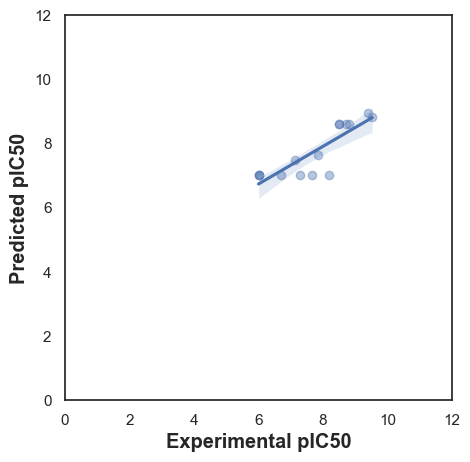

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x = Y_test,y = Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show